Zip Polygon Extractor

In [1]:
import osmnx as ox
import geopandas as gpd
import json
from shapely.geometry import MultiPolygon, Polygon

# Set the default CRS to EPSG:25832
ox.settings.default_crs = "epsg:25832"

# Initialize the GeoDataFrame and the list of dictionaries
gdf = gpd.GeoDataFrame()
mongo_data_list = []

def create_postal_code_gdf(place_name, tags):
    global gdf, mongo_data_list  # Use the global GeoDataFrame and list

    # Fetch place polygons
    place_polygons = ox.features_from_place(place_name, tags)

    # Filter for both Polygons and MultiPolygons
    polygon_mask = place_polygons['geometry'].apply(lambda geom: isinstance(geom, (Polygon, MultiPolygon)))

    # Create GeoDataFrame and drop rows with missing postal_code or geometry
    gdf = gpd.GeoDataFrame(place_polygons[polygon_mask].dropna(subset=['postal_code', 'geometry']))

    # Create a list of dictionaries with postal codes and GeoJSON geometries
    for idx, row in gdf.iterrows():
        postal_code = row['postal_code']
        geometry = row['geometry']

        # Convert Shapely geometry to GeoJSON format
        geojson_geometry = json.loads(gpd.GeoSeries(geometry).to_json())['features'][0]['geometry']

        # Create a dictionary with postal code and GeoJSON geometry
        postal_code_data = {
            "postal_code": postal_code,
            "geometry": geojson_geometry
        }

        # Add to the list
        mongo_data_list.append(postal_code_data)

# Example usage of the function
place_name = "Germany"
tags = {"boundary": "postal_code"}

# Call the function to populate the GeoDataFrame and the list
create_postal_code_gdf(place_name, tags)

# Now 'gdf' contains the GeoDataFrame with postal_code and geometry columns
# 'mongo_data_list' contains the list of dictionaries

# Save GeoJSON data to a file
with open('Germany_postal_codes.geojson', 'w') as file:
    json.dump({"type": "FeatureCollection", "features": mongo_data_list}, file, indent=2)



Plot & Check GeoPandasDataFrame Data

8274

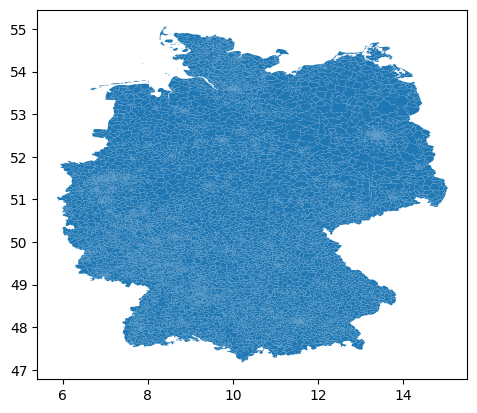

In [7]:
gdf.plot(), 
len(mongo_data_list)

MongoDB Connection & Data Integration

In [2]:
from pymongo import MongoClient
import json

class MongoDBConnector:
    def __init__(self, database_name, collection_name):
        self.client = MongoClient('localhost', 27017)
        self.db = self.client[database_name]
        self.collection = self.db[collection_name]

    def connect_to_local_mongodb(self):
        print("Connected to local MongoDB")
        return self.client, self.collection

    def insert_geojson_data(self, geojson_file_path, chunk_size=1000):
        with open(geojson_file_path, 'r') as file:
            geojson_data = json.load(file)

        # Assuming GeoJSON is a list of features directly
        features = geojson_data['features']
        for i in range(0, len(features), chunk_size):
            chunk = features[i:i + chunk_size]
            self.collection.insert_many(chunk)
            print(f"Inserted {len(chunk)} features into local MongoDB collection '{self.collection.name}'.")

    def close_connection(self):
        self.client.close()
        print("Closed MongoDB connection.")

# Example usage of the class
if __name__ == "__main__":
    # User input for the database and collection names
    database_name = "ZIP_Poly_Ger_DB_e"
    collection_name = "ZIP_Poly_Ger_Collection_e"

    # Create an instance of MongoDBConnector
    mongo_connector = MongoDBConnector(database_name, collection_name)

    # Connect to MongoDB
    mongo_client, mongo_collection = mongo_connector.connect_to_local_mongodb()

    # Example GeoJSON file path
    geojson_file_path = 'Germany_postal_codes.geojson'  # Update the file path accordingly

    # Insert GeoJSON data into MongoDB
    mongo_connector.insert_geojson_data(geojson_file_path, chunk_size=1000)

    # Close MongoDB connection when done
    mongo_connector.close_connection()


Connected to local MongoDB
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_e'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_e'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_e'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_e'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_e'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_e'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_e'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_e'.
Inserted 274 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_e'.
Closed MongoDB connection.


Postal Code to Polygon Converter